In [2]:
import sys
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.optimize import minimize, Bounds

In [3]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

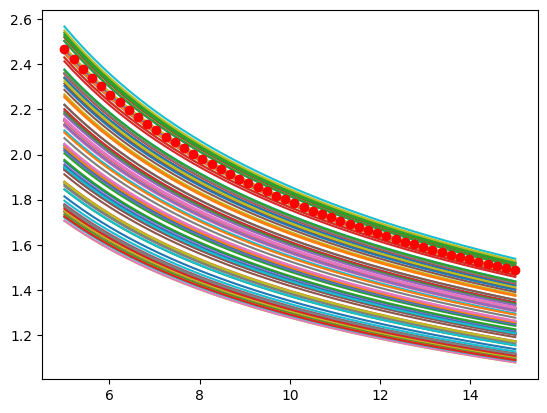

In [4]:
v = np.linspace(5, 15)

for i in range(100): plt.plot(v,v2dh_noised(v))
plt.plot(v, v2dh(v), 'ro')
plt.show()

In [5]:
x = np.linspace(0,100,100)
noise = np.random.rand(100)*100


here


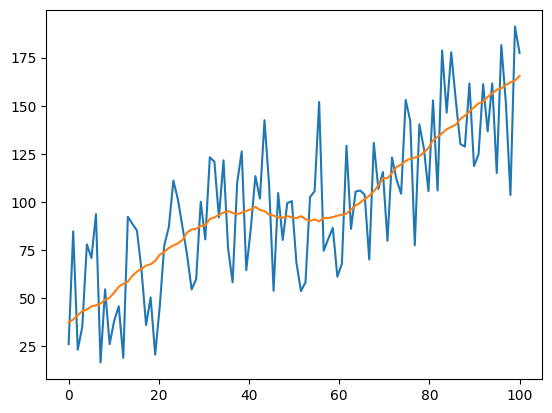

In [6]:
y = x+noise
y = savgol_filter(y, int(len(y)/2), 3, mode='nearest')

plt.plot(x,x+noise)
plt.plot(x,y)

print("here")
plt.show()

In [7]:
print("starting")
num_layers = 80
part_len = 50 #mm
v_min = 5
max_dH = v2dh(v_min)
v_max = 15
min_dH = v2dh(v_max)
points_per_layer = 100

layer_angle = np.arcsin((max_dH-min_dH)/part_len)
rot_point = max_dH/np.tan(layer_angle)-part_len/2
print(np.rad2deg(layer_angle))
print(rot_point)
print(max_dH)
print(min_dH)
print(np.rad2deg(num_layers*layer_angle))

starting
1.1257976619508032
100.6131657840027
2.468475190539253
1.4860946104132609
90.06381295606425


Final Height Error:  12.574026494181997


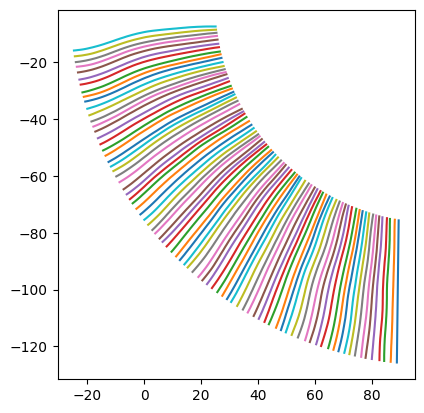

In [18]:


np.random.seed(1234)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)+10
for i in range(1,num_layers):
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_nom)+curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
print("Final Height Error: ", np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])))
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
plt.show()

In [9]:
def delta_v(v):
    delta_v = [v[i]-v[i+1] for i in range(len(v)-1)]
    return delta_v
def v_opt(v_next, v_prev, h_err, h_targ, lam, beta):
    return norm(h_targ+h_err-v2dh(v_next), 2)**2 + lam*norm(v_next-v_prev, 2)**2 + beta*norm(delta_v(v_next), 2)**2

vel_prof = np.linspace(0,100,11)

[ 6.47220931  6.49500734  6.52561458  6.55926351  6.59419007  6.62994654
  6.66633708  6.70342277  6.74104984  6.77930169  6.81810351  6.85756721
  6.89764524  6.93835457  6.97970922  7.02177131  7.06448502  7.10794578
  7.15207112  7.19690205  7.24250147  7.28890433  7.33602982  7.38397101
  7.43265921  7.4821872   7.53257672  7.58383812  7.63594996  7.68893838
  7.74284356  7.79764049  7.85344689  7.9102077   7.96795741  8.02668938
  8.08649563  8.14734243  8.20928545  8.27229179  8.33640979  8.40168192
  8.46813656  8.53581314  8.60468656  8.67481631  8.74622901  8.81894146
  8.89298539  8.96842694  9.04522375  9.12349064  9.20315104  9.28434816
  9.36702831  9.45129976  9.53716857  9.62468281  9.713824    9.80469837
  9.89728986  9.9916586  10.08788464 10.18595465 10.28592528 10.38786637
 10.49177605 10.59770506 10.70579955 10.81601134 10.92843173 11.04305075
 11.15998138 11.27928069 11.40097485 11.52516736 11.65181403 11.7811121
 11.91307758 12.04770111 12.18514948 12.32544325 12.

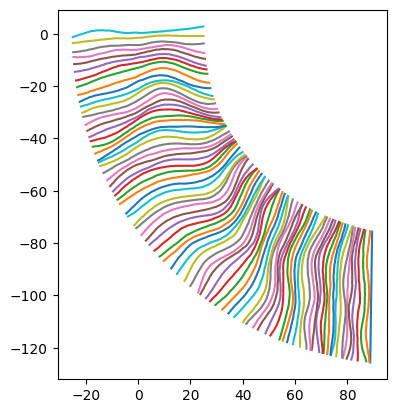

In [20]:
np.random.seed(1)

vel_prev = vel_nom
lam = 1
beta = 1
#constraints
bounds = Bounds(3, 17)

def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*5
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_profile = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_profile)+10
for i in range(1,num_layers):
    try:
        new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
        curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T

        # measure and correct
        height_vals_prev = curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]
        height_err = 0-height_vals_prev
        opt_result=minimize(v_opt, vel_nom, (vel_prev, height_err, height_profile, lam, beta), bounds=bounds,
                            options = {'maxfun':100000})
        if not opt_result.success: 
            print(opt_result)
            raise ValueError(opt_result.message)
        vel_profile = opt_result.x
        print(vel_profile)
        #print("Pre: ", vel_profile)
        # vel_profile = savgol_filter(vel_profile, int(len(vel_profile)/2), 3, mode='nearest')
        #print("Post", vel_profile)
        height_target = height_profile+height_err

        curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
        curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_profile)+height_vals_prev)

        vel_prev = vel_profile
    except:
        break
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
print("Final Height Error: ", np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])))
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
plt.show()